In [1]:
import pybullet as p
import time
import pybullet_data
import numpy as np
import cv2
from pybullet_envs.bullet import racecar

current_dir=/home/dl-box/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/pybullet_envs/bullet


In [2]:
physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-10)
planeId = p.loadURDF("plane.urdf")

In [3]:
p.setAdditionalSearchPath(pybullet_data.getDataPath())
r2d2 = p.loadURDF("r2d2.urdf", [2,0,0.5])

In [3]:
startPos = [0,0,0]
startOrientation = p.getQuaternionFromEuler([0,0,0])
car = racecar.Racecar(p, pybullet_data.getDataPath())

In [5]:
# 2台目
cuid = p.loadURDF("test_car.urdf",[0,1,1], startOrientation)
p.createMultiBody(cuid)

3

In [4]:
#円柱を出現させる
target = p.createCollisionShape(
    p.GEOM_CYLINDER, radius=0.5, height=2, collisionFramePosition=[2,0,0])
vis = p.createVisualShape(
    p.GEOM_CYLINDER, radius=0.5, length=2, visualFramePosition=[2,0,0], rgbaColor=[0,255,0,1])
p.createMultiBody(0, target, vis)

2

In [ ]:
base_pos, orn = p.getBasePositionAndOrientation(car)

In [ ]:
base_pos

In [ ]:
#オブジェクト視点カメラ
cam_eye = np.array(base_pos) + [0.1,0,0.2]
cam_target = [2,0,0.2]
cam_upvec = [1,0,1] #upベクトル(カメラの向きを決める)[1,0,1]で正面？
view_matrix = p.computeViewMatrix(
        cameraEyePosition=cam_eye,
        cameraTargetPosition=cam_target,
        cameraUpVector=cam_upvec)

In [ ]:
cam_eye

In [ ]:
#固定点カメラ
cam_dist = 4 # min 1
cam_yaw = 0
cam_pitch = -10
view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=base_pos,
        distance=cam_dist,
        yaw=cam_yaw,
        pitch=cam_pitch,
        roll=0,
        upAxisIndex=2)

In [ ]:
RENDER_WIDTH = 320
RENDER_HEIGHT = 320
proj_matrix = p.computeProjectionMatrixFOV(
        fov=60, aspect=float(RENDER_WIDTH)/RENDER_HEIGHT,
        nearVal=0.1, farVal=100.0)

In [ ]:
#カメラ画像を取得(width, height, rgb, depth, segment_mask)
(_, _, rgb, _, mask) = p.getCameraImage(
        width=RENDER_WIDTH, height=RENDER_HEIGHT, viewMatrix=view_matrix,
        projectionMatrix=proj_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
#renderer=p.ER_BULLET_HARDWARE_OPENGL or ER_TINY_RENDERER はp.connect(p.DIRECT)のとき

In [ ]:
#np.array形式に変換
rgb_array = np.array(rgb)
rgb_array = rgb_array[:, :, :3]

In [5]:
def render(uniqueId, width=320, height=320):
    base_pos, orn = p.getBasePositionAndOrientation(uniqueId)
    yaw = p.getEulerFromQuaternion(orn)[2]
    rot_matrix = np.array([[np.cos(yaw), -np.sin(yaw)], [np.sin(yaw), np.cos(yaw)]])
    target_relative_vec2D = np.array([2,0])
    target_abs_vec2D = np.dot(rot_matrix, target_relative_vec2D)

    cam_eye = np.array(base_pos) + np.array([0,0,0.2])
    cam_target = np.array(base_pos) + np.append(target_abs_vec2D, 0.2)
    cam_upvec = [0,0,1]

    view_matrix = p.computeViewMatrix(
            cameraEyePosition=cam_eye,
            cameraTargetPosition=cam_target,
            cameraUpVector=cam_upvec)
    proj_matrix = p.computeProjectionMatrixFOV(
        fov=60, aspect=float(width)/height,
        nearVal=0.1, farVal=100.0)

    (_, _, rgb, _, mask) = p.getCameraImage(
        width=width, height=height, viewMatrix=view_matrix,
        projectionMatrix=proj_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
    rgb_array = np.array(rgb)
    rgb_array = rgb_array[:,:,:3]
    mask_array = np.array(mask)
    return rgb_array, mask_array

In [6]:
def green_detect(img):
    '''緑色のマスク'''
    # HSV色空間に変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 緑色のHSVの値域
    hsv_min = np.array([50, 100, 100])
    hsv_max = np.array([70, 255, 255])
    mask = cv2.inRange(hsv, hsv_min, hsv_max)
    return mask

In [8]:
def calc_center(img):
    '''重心座標(x,y)を求める'''
    img = green_detect(img)
    mu = cv2.moments(img, False)
    x, y = int(mu["m10"] / (mu["m00"] + 1e-7)), int(mu["m01"] / (mu["m00"] + 1e-7))
    # 重心を丸でくくる
    cv2.circle(img, (x, y), 4, 100, 2, 4)
    print('x',x,'y',y)
    return img, x, y

x 163 y 128


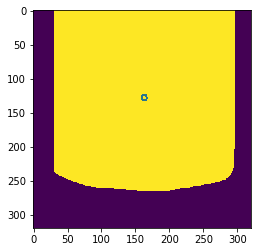

In [18]:
#レンダリングされたカメラ画像を確認
import matplotlib.pyplot as plt
%matplotlib inline
img, mask = render(car.racecarUniqueId)
img, _, _ = calc_center(img)
# plt.imshow(mask, cmap="gray")
plt.imshow(img)

In [14]:
#モーターを動かす
maxForce = 10
velocity = 10
mode = p.VELOCITY_CONTROL
for wheel in range(p.getNumJoints(car)):
    p.setJointMotorControl2(car, wheel, mode, targetVelocity=velocity, force=maxForce)

TypeError: an integer is required (got type Racecar)

In [17]:
#シミュレーション開始
for i in range (1000):
    p.stepSimulation()
#     img, mask = render(car) #renderするととても遅くなる
    time.sleep(1./240.)#世界の時間スピード?

In [16]:
p.getClosestPoints(bodyA=car, bodyB=target, distance=100, linkIndexA=0)[0][8]

-9.99217123331779e-06

In [6]:
p.getJointInfo(car,2)

(2,
 b'front_right_wheel_joint',
 0,
 8,
 7,
 1,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 b'front_right_wheel_link',
 (0.0, 0.0, -1.0),
 (0.15000000596046448, -0.10000000149011612, 0.05000000074505806),
 (-0.7070727411679727, 0.0, 0.0, 0.7071408195665196),
 0)

In [33]:
p.setJointMotorControlArray(
    car, np.arange(p.getNumJoints(car))[1:], p.VELOCITY_CONTROL, 
    targetVelocities=[12,20,12,20],
    forces=np.ones(4)*20)

In [12]:
np.arange(p.getNumJoints(car))[1:]

array([1, 2, 3, 4])